## Анализ данных A/B тестирования

### Описание

Эксперимент проходил с 2022-09-03 по 2022-09-03 включительно. В эсперименте были задействованы 1 и 2 группы. 
В группе 2 был реализован новый алгоритм рекомендации постов, группа 1 использовалась как контрольная.  
**Основная гипотеза** заключается в том, что новый алгоритм во второй группе приведет к увеличению CTR.

### Загрузка данных

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse
import scipy.stats as st
import numpy as np

In [31]:
with open('db.txt') as f:
    host, password, user, database =(i.rstrip() for i in f.readlines())

In [33]:
connection = {'host':host,
              'password': password,
              'user': user,
              'database':database
}

Отбираем с помощью SQL-запроса данные с 2022-09-03 по 2022-09-03 для 1 и 2 экспериментальных групп.

In [34]:
q = """
select exp_group, user_id, 
sum(action='like') as likes,
sum(action='view') as views,
likes/views as ctr
from {db}.feed_actions
where time::date between '2022-09-03' and '2022-09-09'
and exp_group in (1,2)
group by exp_group, user_id"""
df = pandahouse.read_clickhouse(q, connection=connection)

Проверяем количество пользователей в обеих группах

In [16]:
df.exp_group.value_counts()

1    17070
2    16869
Name: exp_group, dtype: int64

Итак, данные корректные, в группах примерно равное число пользователей.

Посмотрим на распределение CTR.

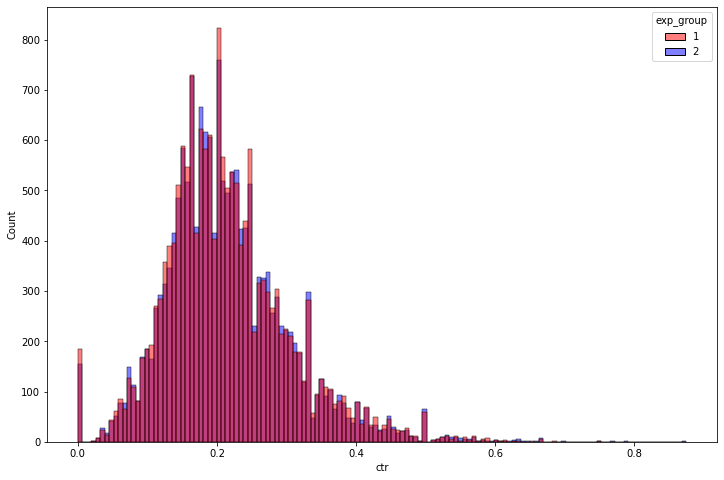

In [17]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'b'], alpha=0.5);

Глядя на этот график, можно сказать, что распределение как в первой, так и во второй группе унимодально, в целом похоже на нормальное, однако имеет большое количество данных около нуля, а также выбросы справа.  
При этом существенных отличий между 1 и 2 группами нет. Подтвердим или опровергнем это предложение с помощью тестов.

### T-критерий Стьюдента и критерий Манна-Уитни

Проведем t-тест. Нулевая гипотеза заключается в равенстве выборочных средних 1 и 2 экспериментральных групп, p-value равен 0.05.

In [18]:
st.ttest_ind(df[df.exp_group==1].ctr,
               df[df.exp_group==2].ctr, equal_var=False)

Ttest_indResult(statistic=-0.41347637473349386, pvalue=0.6792602410005473)

Итак, p-value значительно больше уровня значимости, следовательно, мы не можем опровергнуть нулевую гипотезу.  
Возможно на чуствительность теста повлияли выбросы в наших данных. Расчитаем критерий Манна-Уитни.

In [19]:
st.mannwhitneyu(df[df.exp_group==1].ctr,
               df[df.exp_group==2].ctr,
               alternative= 'two-sided')

MannwhitneyuResult(statistic=143551924.0, pvalue=0.6376814173341009)

Критерий Манна-Уитни также не показал никаких различий между группами

### Пуассоновский бутстреп

Наша задача сравнить общегрупповой CTR в 1 и 2 группах. Трудность в том, что это просто два числа. Получим распределение общегруппового CTR бутстрепом, предположив, что наши выборки из групп являются репрезентативной моделью генеральной совокупности.

In [20]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap = 2000):
    poisson_bootstrap1 = st.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstrap2 = st.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (likes1*poisson_bootstrap1).sum(axis=1)/(views1*poisson_bootstrap1).sum(axis=1)
    globalCTR2 = (likes2*poisson_bootstrap2).sum(axis=1)/(views2*poisson_bootstrap2).sum(axis=1)
    return globalCTR1, globalCTR2

In [21]:
likes1 = df[df.exp_group==1].likes.to_numpy()
views1 = df[df.exp_group==1].views.to_numpy()
likes2 = df[df.exp_group==2].likes.to_numpy()
views2 = df[df.exp_group==2].views.to_numpy()

In [22]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Построим график распределения глобальных CTR

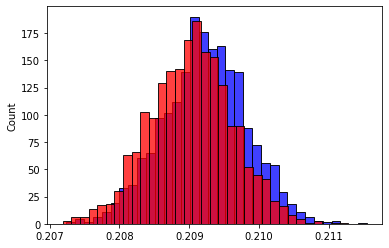

In [23]:
sns.histplot(ctr1, color='blue')
sns.histplot(ctr2, color='red');

Посмотрим на разницу между глобальными CTR 

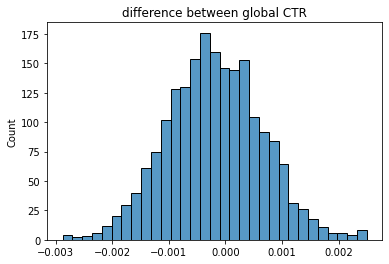

In [24]:
sns.histplot(ctr2-ctr1)
plt.title('difference between global CTR');

**Вывод**  
Значения разницы глобальных CTR 1 и 2 групп сконцентрированы около нуля, что говорит об отсутствии разницы между группами.

### Бакетное преобразование

Попробуем еще один подход для сравнения групп. Разобьем пользователей на 50 бакетов, при этом каждый пользователь попадет только в одну корзину. Разделим пользователей на примерно равные бакеты с помощью хэширования.

In [28]:
q = """select exp_group, bucket,
sum(likes)/sum(views) as bucket_ctr
from(select exp_group, user_id,
xxHash64(user_id)%50 as bucket, 
sum(action='like') as likes, sum(action='view') as views
from {db}.feed_actions
where time::date between '2022-09-03' and '2022-09-09'
and exp_group in (1,2)
group by exp_group, user_id, bucket)
group by exp_group, bucket
"""
df2 = pandahouse.read_clickhouse(q, connection= connection)

In [29]:
df2.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.201306
1,2,0,0.205443
2,1,1,0.208763
3,2,1,0.213816
4,1,2,0.214877


Итак, для каждого из бакетов мы посчитали среднее значение CTR и таким образом получили данные о 50 "метапользователях" для каждой из групп.

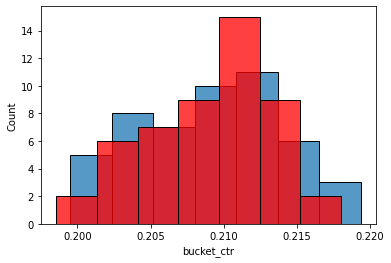

In [9]:
sns.histplot(df2[df2.exp_group==1].bucket_ctr)
sns.histplot(df2[df2.exp_group==2].bucket_ctr, color = 'r');

Распределение бакетного CTR в первой и второй группах получилось похоже на нормальное. 

Применим поверх бакетного преобразования t-тест и критерий Манна-Уитни.

In [6]:
st.ttest_ind(df2[df2.exp_group==1].bucket_ctr,
               df2[df2.exp_group==2].bucket_ctr, equal_var=False)

Ttest_indResult(statistic=0.1580478383755105, pvalue=0.8747496684193465)

In [25]:
st.mannwhitneyu(df2[df2.exp_group==1].bucket_ctr,
               df2[df2.exp_group==2].bucket_ctr,
               alternative='two-sided')

MannwhitneyuResult(statistic=1248.0, pvalue=0.9917494383745994)

Оба теста говорят о невозможности отклонить нулевую гипотезу.

### Вывод

В результате анализа A/B-теста можно сказать, что никаких значимых отличий между группами не обнаружено. Это может означать, что новый алгоритм рекомендации постов не оказал влияния на поведение пользователей (в рамках метрики CTR). Однако это также может свидетельствовать о том, что мощности нашего теста не хватило для фиксирования изменения поведения пользователей. Возможно не хватило чуствительности выбранной метрики или был недостаточный объем выборки. Эксперимент будем считать неудачным, и в  продакшн такой алгоритм запускать нельзя.